In [ ]:
import numpy as np
from scipy.linalg import hankel, svd
from scipy.io import loadmat
import matplotlib.pyplot as plt 
import scipy.signal as signal
import os 
import pandas as pd 
from scipy.signal import find_peaks
from glob import glob  
import math
import pywt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


os.makedirs('results', exist_ok=True)

In [ ]:
def calculate_snr(S, SN):
    """Calculate the Signal-to-Noise Ratio (SNR) between a signal and its noisy version.
    
    Args:
        S (numpy.ndarray): The original signal (clean version)
        SN (numpy.ndarray): The noisy signal
        
    Returns:
        float: The SNR value in decibels (dB)
    """
    S = S-np.mean(S)
    S = S/np.max(np.abs(S))
    mean_S = (np.sum(S))/(len(S))
    PS = np.sum((S-mean_S)*(S-mean_S))
    PN = np.sum((S-SN)*(S-SN))
    # Calculate SNR in decibels using the formula: 10*log10(PS/PN)
    snr=10*math.log((PS/PN), 10)
    return(snr)

In [ ]:
def svt_denoise(time_series, window_size, threshold, max_iters=10, k=1):
    """Perform Singular Value Thresholding (SVT) denoising on a time series using Hankel matrix approach.
    
    Args:
        time_series (numpy.ndarray): Input 1D time series data to be denoised
        window_size (int): Size of the window for constructing Hankel matrix
        threshold (float): Threshold value for singular value shrinkage
        max_iters (int, optional): Maximum number of iterations for denoising. Defaults to 10.
        k (int, optional): Number of smallest singular values to set to zero. Defaults to 1.
        
    Returns:
        tuple: (denoised_series, rank) where:
            denoised_series (numpy.ndarray): The denoised time series
            rank (int): The final rank of the denoised Hankel matrix
            
    Raises:
        ValueError: If window_size exceeds the length of time_series
    """
    n = len(time_series)
    if window_size > n:
        raise ValueError("The window size cannot exceed the length of the time series data.")
    hankel_matrix = hankel(time_series[:window_size], time_series[window_size - 1:])
    for _ in range(max_iters):
        U, sigma, Vt = svd(hankel_matrix, full_matrices=False)
        if len(sigma) > k:
            sigma[-k:] = 0 
        sigma_thresholded = np.maximum(sigma - threshold, 0)
        rank = np.sum(sigma_thresholded > 0)
        hankel_denoised = np.dot(U, np.dot(np.diag(sigma_thresholded), Vt))
        hankel_matrix = hankel_denoised
        if rank < 5: 
            break 
    # Convert the denoised Hankel matrix back to time series
    denoised_series = np.zeros(n)
    count = np.zeros(n)
    # Average the anti-diagonal elements to reconstruct the time series
    for i in range(hankel_denoised.shape[0]):
        for j in range(hankel_denoised.shape[1]):
            denoised_series[i + j] += hankel_denoised[i, j]
            count[i + j] += 1
    # Normalize by the count of elements averaged at each position
    denoised_series /= count
    
    return denoised_series, rank

In [ ]:
def wavelet_denoise(signal, wavelet='db4', level=3, threshold_mode='soft'):
    """Perform wavelet-based denoising on a 1D signal using thresholding of wavelet coefficients.
    
    Args:
        signal (numpy.ndarray): Input 1D signal to be denoised
        wavelet (str, optional): Wavelet type to use (e.g., 'db4' for Daubechies 4). Defaults to 'db4'.
        level (int, optional): Decomposition level for wavelet transform. Defaults to 3.
        threshold_mode (str, optional): Thresholding mode ('soft' or 'hard'). Defaults to 'soft'.
        
    Returns:
        numpy.ndarray: The denoised signal with same length as input
        
    Note:
        Uses the universal threshold (Donoho-Johnstone threshold) for coefficient thresholding
    """
    # Perform wavelet decomposition
    # coeffs is a list of arrays: [cA_n, cD_n, cD_{n-1}, ..., cD_1] where:
    # cA_n is the approximation coefficients at level n
    # cD_n...cD_1 are detail coefficients at different levels
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Estimate noise standard deviation using the Median Absolute Deviation (MAD)
    # of the finest level detail coefficients (assumed to be mostly noise)
    # The factor 0.6745 makes it a consistent estimator for Gaussian noise
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    # Calculate universal threshold (Donoho-Johnstone threshold)
    # This threshold is optimal in a minimax sense for signals with white noise
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresholded = []
    coeffs_thresholded.append(coeffs[0])
    for i in range(1, len(coeffs)):
        coeffs_thresholded.append(pywt.threshold(coeffs[i], threshold, mode=threshold_mode))
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet)
    # Handle potential length mismatches between input and reconstructed signal
    if len(denoised_signal) > len(signal):
        denoised_signal = denoised_signal[:len(signal)]
    elif len(denoised_signal) < len(signal):
        denoised_signal = np.pad(denoised_signal, (0, len(signal) - len(denoised_signal)), 'constant')
    return denoised_signal

In [ ]:
def find_r_peaks(ecg_signal, sampling_rate=100, height=0.5):
    """Detect R-peaks in an ECG signal using peak detection algorithm.
    
    Args:
        ecg_signal (numpy.ndarray): 1D array containing the ECG signal
        sampling_rate (int, optional): Sampling rate of the ECG signal in Hz. Defaults to 100.
        height (float, optional): Minimum height required for peak detection. Defaults to 0.5.
        
    Returns:
        tuple: (r_peaks, r_peaks_times) where:
            r_peaks (numpy.ndarray): Array of indices where R-peaks occur in the ECG signal
            r_peaks_times (numpy.ndarray): Array of timestamps (in seconds) for each R-peak
            
    Note:
        Uses scipy.signal.find_peaks for peak detection with physiological constraints
    """
    r_peaks, _ = find_peaks(ecg_signal, height=height, distance=sampling_rate/2)
    # Convert peak indices to timestamps in second
    r_peaks_times = r_peaks / sampling_rate
    return r_peaks, r_peaks_times

In [ ]:
def plot_ecg_with_r_peaks(ecg_signal, sampling_rate=100, height=0.5):
    """Plot ECG signal with detected R-peaks marked.
    
    Args:
        ecg_signal (numpy.ndarray): 1D array containing the ECG signal
        sampling_rate (int, optional): Sampling rate of the ECG signal in Hz. Defaults to 100.
        height (float, optional): Minimum height threshold for R-peak detection. Defaults to 0.5.
        
    Returns:
        None: Displays a matplotlib plot of the ECG with marked R-peaks
        
    Note:
        Requires matplotlib.pyplot as plt and numpy as np
        Uses find_r_peaks() function for R-peak detection
    """
    r_peaks, r_peaks_times = find_r_peaks(ecg_signal, sampling_rate, height=height)
    time = np.arange(0, len(ecg_signal)) / sampling_rate
    plt.figure(figsize=(14, 4))
    plt.plot(time, ecg_signal, label='ECG Signal')
    plt.plot(r_peaks_times, ecg_signal[r_peaks], 'ro', label='R-peaks')
    plt.title('ECG Signal with R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

### Simulation data

In [ ]:
# Create directory for storing results if it doesn't exist
# exist_ok=True prevents errors if directory already exists
os.makedirs('results/simulation', exist_ok=True)

# Path to MATLAB data file containing simulation data
file_path = 'dataset_simulation/signal000.mat'

# Load MATLAB .mat file containing ECG simulation data
# Returns a dictionary-like object with variable names as keys
data = loadmat(file_path)
data.keys()

# Extract real ECG beat template from the data
# 'beat_signal' appears to contain a template ECG beat
real_data = data['beat_signal'][0]

# Extract simulated noisy ECG signal from the data
# 'signal15' appears to be one of the simulated noisy ECG signals
dat = data['signal15'][0]

In [ ]:
# Set sampling frequency (Hz) - typically 100-1000Hz for ECG signals
fs = 100

# Create time vector for 1 second of signal with 1000 points
# endpoint=False prevents including both 0 and 1 in the array
t = np.linspace(0, 1, 1000, endpoint=False) 

# Set bandpass filter cutoff frequencies (Hz)
low_cut = 2  
high_cut = 25 

# Calculate Nyquist frequency (half of sampling rate)
nyquist = fs / 2 

# Normalize cutoff frequencies to Nyquist frequency (required for digital filters)
low = low_cut / nyquist
high = high_cut / nyquist

# Set filter order (higher order = steeper roll-off but potential instability)
order = 1  

# Design Butterworth bandpass filter coefficients
# b = numerator coefficients, a = denominator coefficients
# btype='band' specifies bandpass filter
b, a = signal.butter(order, [low, high], btype='band')

# Apply zero-phase filtering using forward-backward filtfilt
# filtfilt avoids phase distortion by filtering twice (forward and backward)
filtered_signal = signal.filtfilt(b, a, dat)

In [ ]:
# Test different threshold values for SVT denoising
# Threshold controls how aggressively we shrink singular values
window_size = 200
snrs = {}
ranks = {}
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5]:
    snrs[threshold] = []
    ranks[threshold] = []
    for max_iters in [5] + list(range(10, 101, 10)):
        denoised_signal, rank = svt_denoise(filtered_signal, window_size, threshold, max_iters=max_iters, k=1)
        after_denoied_db = calculate_snr(real_data, denoised_signal)
        snrs[threshold].append(after_denoied_db)
        ranks[threshold].append(rank)


In [ ]:
# plot the results
df = pd.DataFrame(snrs)
df.index = [5] + list(range(10, 101, 10))

df = df.sort_index(ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'SNR'})
plt.xlabel('Threshold')
plt.ylabel('Iterations')
plt.savefig('results/SVT_param.pdf')

df.to_csv('results/SVT_parm.csv', index=True)

In [ ]:
# Define wavelet families to test (Daubechies wavelets 1 through 10)
wavelets = ['db1','db2','db3','db4','db5','db6','db7','db8','db9','db10']
# Define decomposition levels to test (1 through 6)
levels = [1,2,3,4,5,6]
df = pd.DataFrame()
for wavelet in wavelets:
    for level in levels:
        wavelet_denoised_signal = wavelet_denoise(filtered_signal, wavelet=wavelet, level=level)
        wavelet_snr = calculate_snr(real_data, wavelet_denoised_signal)
        df.loc[wavelet, f"Level{level}"] = wavelet_snr
        print(f"Wavelet={wavelet} | Level={level} | SNR={wavelet_snr:.3f}")

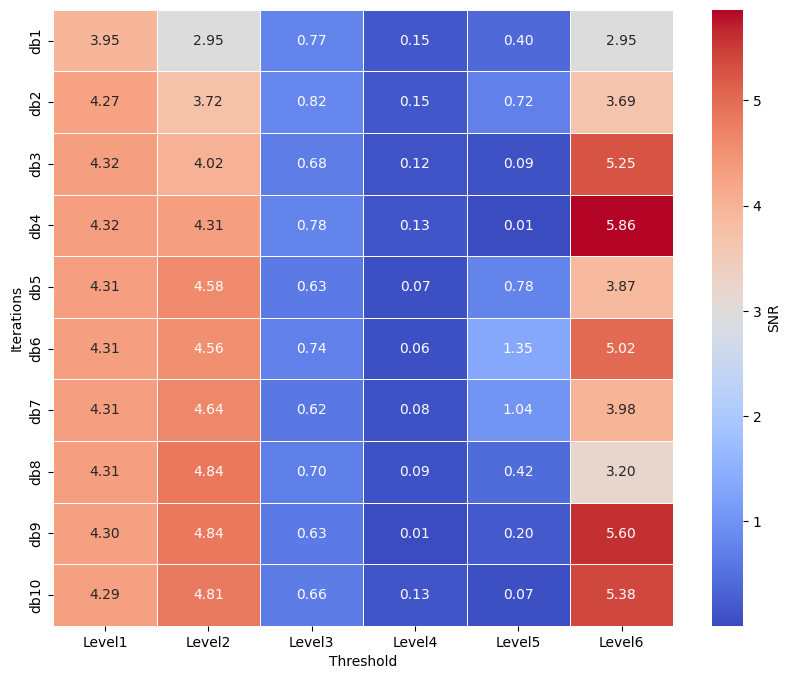

In [ ]:
# plot the results
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={'label': 'SNR'})
plt.xlabel('Threshold')
plt.ylabel('Iterations')
plt.savefig('results/wavelet_param.pdf')

In [ ]:
# plot the results

window_size = 200
threshold = 1.9
denoised_signal, rank = svt_denoise(filtered_signal, window_size, threshold, max_iters=10, k=1)
print('rank', rank)
before_denoied_db = calculate_snr(real_data, filtered_signal)
after_denoied_db = calculate_snr(real_data, denoised_signal)
print(f"Before Denoised SNR={before_denoied_db:.3f}")
print(f"After Denoised SNR={after_denoied_db:.3f}")

outdir = f'results/simulation/threshold_{threshold}_rank_{rank}/'
os.makedirs(outdir, exist_ok=True)
# save data
pd.DataFrame({'Original_Signal': dat, 
              'Filtered_Signal': filtered_signal, 
              'Denoised_Signal': denoised_signal, 
              'Beat_Signal':data['beat_signal'][0]
              }).to_csv(os.path.join(outdir, 'signal.csv'), index=False)
with open(os.path.join(outdir, 'log.txt'), 'w') as FO:
    FO.writelines(f"Before Denoised SNR={before_denoied_db:.3f}\n")
    FO.writelines(f"After Denoised SNR={after_denoied_db:.3f}\n")


t = np.array(list(range(len(denoised_signal)))) / 100
sigbplots = 4
plt.figure(figsize=(10, 6))
plt.subplot(sigbplots, 1, 1)
plt.plot(t, dat)
plt.title('Original Signal')
plt.ylabel('Amplitude')

plt.subplot(sigbplots, 1, 2)
plt.plot(t, filtered_signal, color='orange')
plt.title('Filtered Signal (2~25Hz)')
plt.ylabel('Amplitude')

plt.subplot(sigbplots, 1, 3)
plt.plot(t, denoised_signal, color='grey')
plt.title('Denoised Signal with SVT')
plt.ylabel('Amplitude')

plt.subplot(sigbplots, 1, 4)
plt.plot(t, data['beat_signal'][0], color='red')
plt.title('Beat Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'signal.pdf'))

In [ ]:
# plot the results

window_size = 200
threshold = 1
for threshold in [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]:
    print('\nthreshold:', threshold)
    denoised_signal, rank = svt_denoise(filtered_signal, window_size, threshold, max_iters=20, k=1)

    before_denoied_db = calculate_snr(real_data, filtered_signal)
    after_denoied_db = calculate_snr(real_data, denoised_signal)
    print(f"Before Denoised SNR={before_denoied_db:.3f}")
    print(f"After Denoised SNR={after_denoied_db:.3f}")
    print('rank', rank)

    outdir = f'results/simulation/threshold_{threshold}_rank_{rank}/'
    os.makedirs(outdir, exist_ok=True)
    # save data
    pd.DataFrame({'Original_Signal': dat, 
                'Filtered_Signal': filtered_signal, 
                'Denoised_Signal': denoised_signal, 
                'Beat_Signal':data['beat_signal'][0]
                }).to_csv(os.path.join(outdir, 'signal.csv'), index=False)
    with open(os.path.join(outdir, 'log.txt'), 'w') as FO:
        FO.writelines(f"Before Denoised SNR={before_denoied_db:.3f}\n")
        FO.writelines(f"After Denoised SNR={after_denoied_db:.3f}\n")
        FO.writelines(f"Rank={rank}\n")


    sigbplots = 4
    plt.figure(figsize=(10, 6))
    plt.subplot(sigbplots, 1, 1)
    plt.plot(t, dat)
    plt.title('Original Signal')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 2)
    plt.plot(t, filtered_signal, color='orange')
    plt.title('Filtered Signal (2~25Hz)')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 3)
    plt.plot(t, denoised_signal, color='grey')
    plt.title('Denoised Signal with SVT')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 4)
    plt.plot(t, data['beat_signal'][0], color='red')
    plt.title('Beat Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'signal.pdf'))

### Human Dataset

In [ ]:
def preprocess_bcg(bcg, ecg, human_id, threshold=10, rank=None):
    """
    Preprocesses BCG (Ballistocardiogram) signals by denoising and visualizing alongside ECG.
    
    Args:
        bcg (array): Raw BCG signal
        ecg (array): Corresponding ECG signal
        human_id (str): Identifier for the subject
        threshold (float): Threshold for SVT denoising (default: 10)
        rank (int, optional): Force rank for SVT (default: None = auto-determined)
    
    Returns:
        array: Denoised BCG signal
    """
    t = np.array(list(range(len(bcg)))) / 100
    window_size = 200
    threshold = 1.9
    denoised_signal, rank = svt_denoise(bcg, window_size, threshold, max_iters=10, k=1)
    print(denoised_signal.shape)
    outdir = f'results/human/{human_id}/'
    os.makedirs(outdir, exist_ok=True)
    # save data
    pd.DataFrame({'Original_BCG_Signal': bcg, 
                'ecg': ecg, 
                'Denoised_BCG_Signal': denoised_signal
                }).to_csv(os.path.join(outdir, 'signal.csv'), index=False)

    sigbplots = 3
    plt.figure(figsize=(10, 6))
    plt.subplot(sigbplots, 1, 1)
    plt.plot(t, bcg)
    plt.title('BCG Original Signal')
    plt.ylabel('Amplitude')

    # plt.subplot(sigbplots, 1, 2)
    # plt.plot(t, filtered_signal, color='orange')
    # plt.title('BCG Filtered Signal (2~25Hz)')
    # plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 2)
    plt.plot(t, denoised_signal, color='grey')
    plt.title('BCG Denoised Signal with SVT')
    plt.ylabel('Amplitude')

    plt.subplot(sigbplots, 1, 3)
    plt.plot(t, ecg, color='red')
    plt.title('ECG Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')


    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'signal.pdf'))
    
    return denoised_signal


def plot_ecg_with_r_peaks(ecg_signal, sampling_rate=100, height=0.5, human_id='Id'):
    """
    Visualizes ECG signal with detected R-peaks and saves plot.
    
    Args:
        ecg_signal (array): ECG signal
        sampling_rate (int): Sampling frequency in Hz (default: 100)
        height (float): Minimum peak height (default: 0.5)
        human_id (str): Subject identifier
        
    Returns:
        tuple: (r_peaks, r_peaks_times) indices and timestamps
    """
    r_peaks, r_peaks_times = find_r_peaks(ecg_signal, sampling_rate, height=height)
    time = np.arange(0, len(ecg_signal)) / sampling_rate
    plt.figure(figsize=(14, 4))
    plt.plot(time, ecg_signal, label='ECG Signal')

    plt.plot(r_peaks_times, ecg_signal[r_peaks], 'ro', label='R-peaks')
    
    plt.title('ECG Signal with R-peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    return r_peaks, r_peaks_times

In [ ]:
# Get all sample information
files = glob('dataset_hm/*mat')
print('Sample Number: ', len(files))

for infile in files:
    data = loadmat(infile)
    bcg = data['beat'].flatten()
    ecg = data['v2'].flatten()

    if np.sum(ecg == 0) == len(ecg):
        continue

    if len(ecg) != len(bcg):
        continue
    human_id = os.path.basename(infile).split('.')[0]
    denoised_signal = preprocess_bcg(bcg, ecg, human_id)



In [ ]:
# Execute a single sample
human_ids = os.listdir('results/human')
idx = 159
human_id = human_ids[idx]

df = pd.read_csv(f'results/human/{human_id}/signal.csv')
ecg = df.ecg.values
denoised_signal = df.Denoised_BCG_Signal.values

bcg_peaks, bcg_peaks_times = plot_ecg_with_r_peaks(denoised_signal, height=0.0)
pd.DataFrame({'BCG_Peark_Point': bcg_peaks, 
            'BCG_Peark_Times': bcg_peaks_times, 
            }).to_csv(f'results/human/{human_id}/{human_id}_BCG.csv', index=False)
print(len(bcg_peaks))

ecg_peaks, ecg_peaks_times = plot_ecg_with_r_peaks(ecg, height=0.31)
pd.DataFrame({'ECG_Peark_Point': ecg_peaks, 
            'ECG_Peark_Times': ecg_peaks_times, 
            }).to_csv(f'results/human/{human_id}/{human_id}_ECG.csv', index=False)

print(len(ecg_peaks))

### Analyze the results

In [410]:
bcg_files = glob('results/human/*/*BCG.csv')
ecg_files = glob('results/human/*/*ECG.csv')

In [411]:
bcg_preak_numbers = [pd.read_csv(infile).shape[0] for infile in bcg_files]
ecg_preak_numbers = [pd.read_csv(infile).shape[0] for infile in ecg_files]

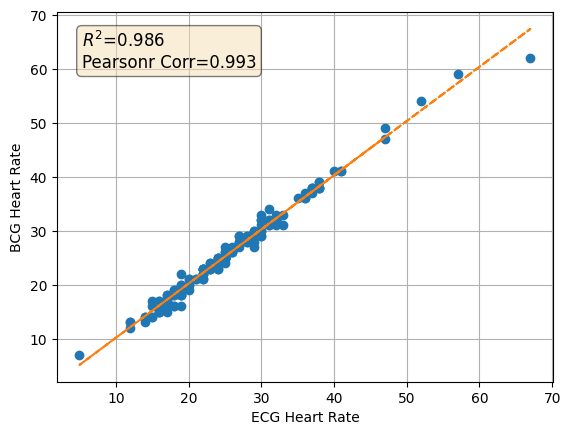

In [ ]:
# Calculating correlation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

fit = np.polyfit(ecg_preak_numbers, bcg_preak_numbers, deg=1)
predicted = np.polyval(fit, ecg_preak_numbers)

r2 = r2_score(bcg_preak_numbers, predicted)
correlation, _ = pearsonr(ecg_preak_numbers, bcg_preak_numbers)

plt.plot(ecg_preak_numbers, bcg_preak_numbers, 'o', label='Data points')
plt.plot(ecg_preak_numbers, predicted, '--', label=f'Fit line: y={fit[0]:.2f}x+{fit[1]:.2f}')
plt.text(0.05, 0.95, f'$R^2$={r2:.3f}\nPearsonr Corr={correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
# plt.legend()
plt.xlabel('ECG Heart Rate')
plt.ylabel('BCG Heart Rate')
# plt.title('Scatter Plot with R2 and Correlation')
plt.grid(True)
plt.savefig('results/fig1.pdf')
pd.DataFrame({'ecg_preak_numbers': ecg_preak_numbers,
              'bcg_preak_numbers': bcg_preak_numbers
              }).to_csv('results/heart_rate_numbers.csv', index=False)

In [386]:
total_diff_times = []
for idx,_ in enumerate(bcg_files):
    tb1 = pd.read_csv(bcg_files[idx])
    tb2 = pd.read_csv(ecg_files[idx])
    diff_times = [np.min(np.abs(t - tb2.ECG_Peark_Times.values)) for t in tb1.BCG_Peark_Times.values]
    total_diff_times.extend(diff_times)

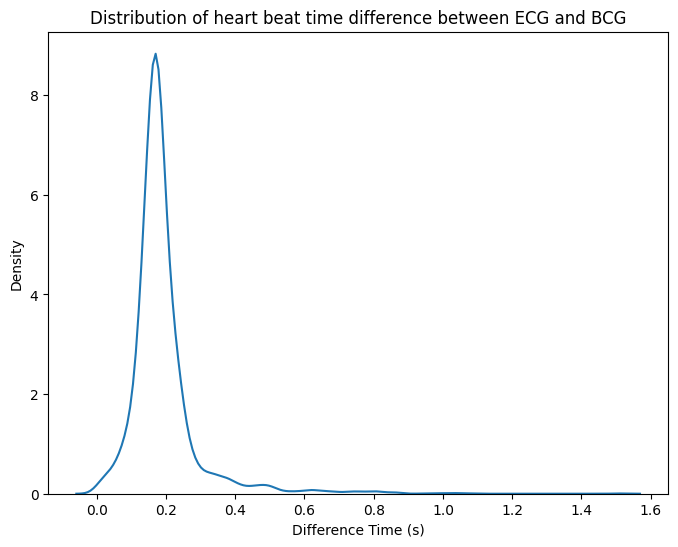

In [406]:
import seaborn as sns 

plt.figure(figsize=(8,6))
sns.kdeplot(total_diff_times)
plt.xlabel('Difference Time (s)')
plt.title('Distribution of heart beat time difference between ECG and BCG')
plt.savefig('results/fig2.pdf')
np.savetxt('results/Difference_Time.txt', total_diff_times)

In [ ]:
total_diff_times = []
for idx,_ in enumerate(bcg_files):
    tb1 = pd.read_csv(bcg_files[idx])
    tb2 = pd.read_csv(ecg_files[idx])
    diff_times = [np.min(np.abs(t - tb2.ECG_Peark_Times.values)) for t in tb1.BCG_Peark_Times.values]
    total_diff_times.extend(diff_times)

In [399]:
bcg_times = []
ecg_times = []
for idx,_ in enumerate(bcg_files):
    tb1 = pd.read_csv(bcg_files[idx])
    tb2 = pd.read_csv(ecg_files[idx])
    for t in tb1.BCG_Peark_Times.values:
        i = np.argmin(np.abs(t - tb2.ECG_Peark_Times.values))
        bcg_times.append(t)
        ecg_times.append(tb2.ECG_Peark_Times.values[i])

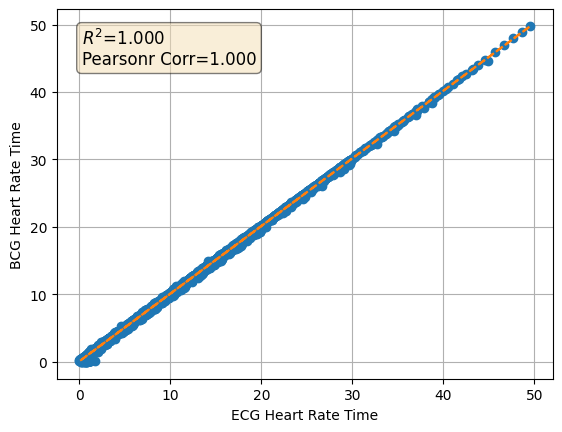

In [ ]:
fit = np.polyfit(ecg_times, bcg_times, deg=1)
predicted = np.polyval(fit, ecg_times)

r2 = r2_score(bcg_times, predicted)
correlation, _ = pearsonr(ecg_times, bcg_times)

plt.plot(ecg_times, bcg_times, 'o', label='Data points')
plt.plot(ecg_times, predicted, '--', label=f'Fit line: y={fit[0]:.2f}x+{fit[1]:.2f}')
plt.text(0.05, 0.95, f'$R^2$={r2:.3f}\nPearsonr Corr={correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# plt.legend()
plt.xlabel('ECG Heart Rate Time')
plt.ylabel('BCG Heart Rate Time')
# plt.title('Scatter Plot with R2 and Correlation')
plt.grid(True)
plt.savefig('results/fig3.pdf')

pd.DataFrame({'ecg_times': ecg_times,
              'bcg_times': bcg_times
              }).to_csv('results/heart_rate_times.csv', index=False)